In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from quickdraw import QuickDrawDataGroup, QuickDrawData
import pandas as pd
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
import cv2
import os
from pathlib import Path
from tensorflow.image import grayscale_to_rgb

In [16]:
raw_data_path = os.path.join(os.getcwd(), '..', 'raw_data')
reduced_data_path = os.path.join(os.getcwd(), '..', 'reduced_data')
raw_data_path, reduced_data_path

('/home/psousa01/code/psousa01/doodle-project/notebooks/../raw_data',
 '/home/psousa01/code/psousa01/doodle-project/notebooks/../reduced_data')

In [17]:
# image_size = (64,64)

# def generate_class_images(name, max_drawings, recognized):
#     directory = Path(os.path.join(raw_data_path, name))

#     if not directory.exists():
#         directory.mkdir(parents=True) # Creates label directory if it doesn't exist

#     images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    
#     for img in images.drawings:
#         """Save all the images in the label group in a subdirectory as png"""
#         filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
#         img.get_image(stroke_width=3).resize(image_size).save(filename)

# for label in QuickDrawData().drawing_names:
#     """Get 1200 recognized images per label"""
#     generate_class_images(label, max_drawings=1200, recognized=True)

# Creating the train and validation datasets

In [13]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [104]:
# Reduced dataset with 5 clasees

batch_size = 32
image_size = (64,64)

train_ds = image_dataset_from_directory(
    reduced_data_path,
    validation_split=0.2,
    label_mode='int',
    labels = 'inferred',
    subset="training",
    seed=123,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    reduced_data_path,
    validation_split=0.2,
    label_mode='int',
    labels='inferred',
    subset="validation",
    seed=123,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size
)


Found 6000 files belonging to 5 classes.
Using 4800 files for training.
Found 6000 files belonging to 5 classes.
Using 1200 files for validation.


In [105]:
## Full dataset with 345 clasees

# batch_size = 32
# image_size = (64,64)

# train_ds = image_dataset_from_directory(
#     raw_data_path,
#     validation_split=0.2,
#     labels = 'inferred',
#     subset="training",
#     seed=123,
#     color_mode="rgb",
#     image_size=image_size,
#     batch_size=batch_size
# )

# val_ds = image_dataset_from_directory(
#     raw_data_path,
#     validation_split=0.2,
#     labels='inferred',
#     subset="validation",
#     seed=123,
#     color_mode="rgb",
#     image_size=image_size,
#     batch_size=batch_size
# )


In [106]:
train_ds.class_names

['airplane', 'apple', 'cat', 'dog', 'mountain']

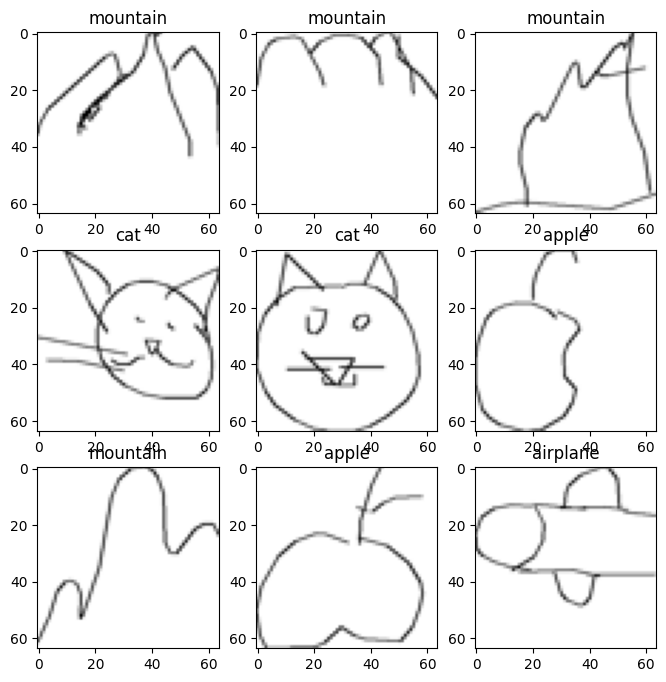

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i, l in train_ds.take(1):
    for j in range(9):
        fig = plt.subplot(3,3,j+1)
        fig.imshow(i[j].numpy().astype('uint8'))
        fig.set_title(train_ds.class_names[l[j]])

# Importing VGG16 with non trainable weights

In [117]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers

In [118]:
# Initialize the VGG16 model

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(64,64,3)
)

In [129]:
inputs = layers.Input(shape = (64,64,3))

x = preprocess_input(inputs)
x = base_model(x)

x = layers.Flatten()(x)

x = layers.Dense(600, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(500, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(400, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(5, activation = 'softmax')(x) # 5 IS FOR REDUCED DATASET, CHANGE TO 345 WHEN USING FULL


model = Model(inputs = inputs, outputs = pred)

base_model.trainable = False

In [130]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_7   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 600)               1229

In [131]:
adam = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Training our model with VGG16 weights

In [134]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 5, restore_best_weights = True, verbose = 1)

In [133]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 50,
    callbacks=[es]
)

Epoch 1/50
150/150 [==============================] - 4s 17ms/step - loss: 0.5363 - accuracy: 0.8213 - val_loss: 0.2996 - val_accuracy: 0.8908
Epoch 2/50
150/150 [==============================] - 2s 15ms/step - loss: 0.2902 - accuracy: 0.9006 - val_loss: 0.2490 - val_accuracy: 0.9033
Epoch 3/50
150/150 [==============================] - 2s 15ms/step - loss: 0.2285 - accuracy: 0.9196 - val_loss: 0.2583 - val_accuracy: 0.9092
Epoch 4/50
150/150 [==============================] - 2s 15ms/step - loss: 0.2276 - accuracy: 0.9246 - val_loss: 0.2359 - val_accuracy: 0.9083
Epoch 5/50
150/150 [==============================] - 2s 15ms/step - loss: 0.1687 - accuracy: 0.9360 - val_loss: 0.2328 - val_accuracy: 0.9192
Epoch 6/50
150/150 [==============================] - 2s 15ms/step - loss: 0.1576 - accuracy: 0.9435 - val_loss: 0.2489 - val_accuracy: 0.9092
Epoch 7/50
150/150 [==============================] - 2s 15ms/step - loss: 0.1319 - accuracy: 0.9533 - val_loss: 0.3382 - val_accuracy: 0.8833

In [143]:
model.evaluate(val_ds)

38/38 [==============================] - 1s 11ms/step - loss: 0.2328 - accuracy: 0.9192


[0.23284505307674408, 0.9191666841506958]